# Desarrollo
El presente trabajo práctico consiste en aplicar una serie de métricas y modelos sobre un set de datos que representa una red de vuelos directos entre países.  
Como se prioriza el análisis de los resultados se utilizaran herramientas que nos proveen de dichas métricas y representaciones gráficas como NetworkX, Matplotlib (provistos por Python) y Gephi.  

# Punto 1  
## a. El diámetro de la red.  
Primero creamos nuestro grafo a partir del set de datos World.csv que nos proveen.

In [37]:
from collections import deque
import csv

graph = {}

with open('World.csv', 'r') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    next(csv_reader) #remove header
    for row in csv_reader:
        if row[0] not in graph:
            graph[row[0]] = set()
        graph[row[0]].add(row[1])


De esta forma graph será un diccionario que representa nuestra red, donde cada clave será el nombre de un nodo y su valor la lista de vecinos de dicho nodo.  
  
El diámetro está definido como la mayor de las distancias entre todos los pares de vértices del grafo. Para hallarlo aplicamos el algoritmo BFS para obtener el camino mínimo para cada par de nodos. El diámetro será el largo máximo de todos los caminos mínimos.

In [38]:
def graph_diameter(graph):
    max_diameter = 0
    for node in graph:
        distances = bfs(graph, node)
        max_distance = max(distances.values())
        max_diameter = max(max_diameter, max_distance)
    return max_diameter


def bfs(graph, start):
    visited = set()
    queue = deque([(start, 0)])
    distances = {start: 0}

    while queue:
        node, dist = queue.popleft()

        if node not in visited:
            visited.add(node)
            for neighbor in graph.get(node, []):
                if neighbor not in distances:
                    distances[neighbor] = dist + 1
                    queue.append((neighbor, dist + 1))

    return distances

print(f'Network diameter: {graph_diameter(graph)}')

Network diameter: 7


## b. El grado promedio de la red.
Para el resto del análisis puede resultar menos ágil trabajar con el grafo representado como un diccionario y desarrollar los algoritmos por nosotros mismos. Por lo que optamos por utilizar la biblioteca NetworkX de Python, que proporciona funcionalidades integradas para trabajar con redes.  
  
Representamos la red como un grafo de la siguiente manera:

In [39]:
import networkx as nx

nx_graph = nx.DiGraph()

for node, neighbors in graph.items():
    nx_graph.add_node(node, name=node)
    for neighbor in neighbors:
        nx_graph.add_edge(node, neighbor)

Utilizamos la función degree para calcular el grado de cada nodo de la red.  

In [40]:
import math

average_degree = sum(dict(nx_graph.degree()).values()) / len(nx_graph)
print(f'Average degree: {math.ceil(average_degree)}')

Average degree: 25


## c. El coeficiente de clustering promedio de la red.
Dicho coeficiente se obtiene como la cantidad de triángulos dividida la cantidad de triángulos que se podrían generar.

In [41]:
clustering_coefficient = nx.average_clustering(nx_graph)
print(f'Clustering coefficient: {round(clustering_coefficient, 2)}')

Clustering coefficient: 0.33


# Punto 2
## a. Indicar si existe algún tipo de Homofilia y qué tipo de homofilia es. Si no hay homofilia por ningún criterio, explicar. Justificar detalladamente.

## b. Obtener una visualización de las comunidades presentes en dicha red (indicando el algoritmo utilizado).

Si bien se obtuvo la representación gráfica de las comunidades de la red utilizando Gephi, a continuación se procede a detectarlas utilizado herramientas provistas por NetworkX para quedarnos con un subgrafo que será utilizando en análisis posteriores.  
Para esto detectamos comunidades utilizando el algoritmo de modularity.

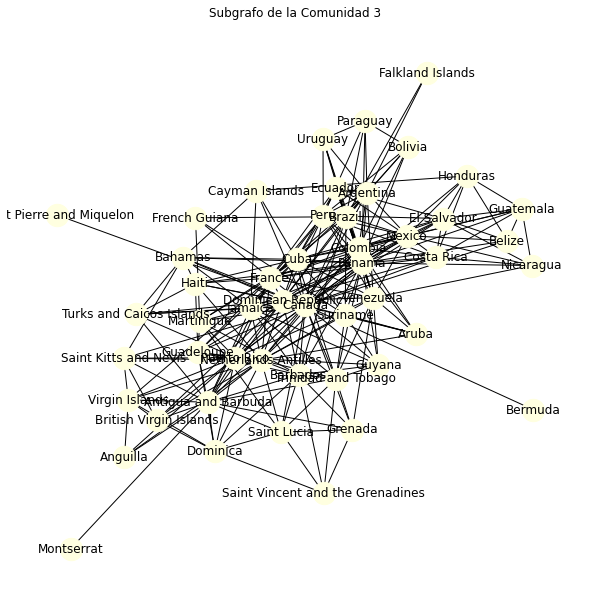

In [64]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt

G = nx.Graph()

# Detectar comunidades utilizando el algoritmo de modularity
communities = list(greedy_modularity_communities(nx_graph))

subgraph = nx.Graph()
community_nodes = list(communities[2])
subgraph.add_nodes_from(community_nodes)

for node1 in community_nodes:
    for node2 in community_nodes:
        if node1 != node2 and nx_graph.has_edge(node1, node2):
            subgraph.add_edge(node1, node2)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color='lightyellow')
plt.title('Subgrafo de la Comunidad 3')
plt.show()

## c. Considerando lo mencionado en el punto (2.a), ¿corresponde lo encontrado por el algoritmo de detección de comunidades en relación a lo indicado en dicho punto? ¿Se verifica que efectivamente hay homofilia, o no, según hayas indicado? ¿como contrastan este resultado con lo indicado (y calculado) anteriormente?

# Punto 3
## a. Determinar un tipo de centralidad que podría ser útil calcular para esta red, justificando.

Con la centralidad buscamos definir cuales son los nodos más importantes o influyentes. Depende del contexto de la red cuál métrica tendrá más sentido aplicar.  
Para el set de datos dado consideramos útil calcular Betweenness Centrality, ya que la misma nos brinda la cantidad de veces que un vértice aparece como intermediario en algún camino mínimo. Como nuestro problema se trata de vuelos entre ciudades, visualizar dichos nodos nos permitirá ver qué lugares pueden servir como puntos de escalas. Es decir, aquellos lugares desde donde se puede llegar a más destinos o a los que se puede acceder desde múltiples destinos.  
Esta centralidad nos permite ver puntos estratégicos en la red de vuelos, los cuales pueden ser importantes para conexiones de vuelos, planificación de rutas. También podría ayudar a las aerolíneas a optimizar los servicios de vuelos. Se podría detectar en qué ciudades habrá mayor congestión por ser más probable recibir un mayor número de pasajeros al haber más conexiones.  
En resumen podemos ver la importancia de las ciudades en nuestra red de vuelos.  
  
## b. Realizar una representación gráfica de dicha red, considerando la centralidad de los distintos países dada por la métrica del punto a (tamaño de los nodos proporcional a dicha métrica).

In [42]:
betweenness_centrality = nx.betweenness_centrality(nx_graph)

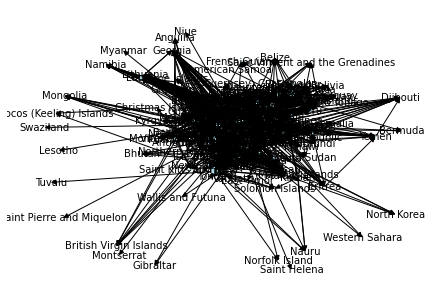

In [43]:
import matplotlib.pyplot as plt

node_sizes = [2000 * betweenness_centrality[node] for node in nx_graph.nodes]
pos = nx.spring_layout(nx_graph, k=0.2, iterations=50)  # Posicionamiento de los nodos
nx.draw(nx_graph, pos, with_labels=True, node_size=node_sizes, node_color='lightblue', font_size=10)
plt.show()

Si bien se puede jugar con los parámetros k e iteration del spring layout, optamos por utilizar la herramienta Gephi que resulta más amigable a la hora de visualizar nuestra red. Además nos provee de diferentes cálculos de centralidad.  
La representación gráfica se muestra en el informe.

# Punto 4
## a. Obtener una simulación de un modelado de Erdös-Rényi que corresponda a los parámetros de esta red.  

La cantidad de nodos en el grafo es: 229


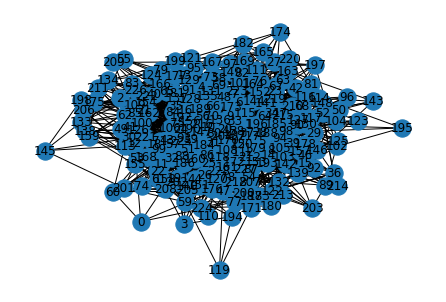

In [44]:
# Número de aeropuertos en la red
num_nodes = nx_graph.number_of_nodes()
average_degree = 12.454

print(f"La cantidad de nodos en el grafo es: {num_nodes}")

# Probabilidad de conexión entre aeropuertos
p =  average_degree / (num_nodes - 1)

# Crear el grafo de Erdős-Rényi de vuelos
nx_graph_erdos_renyi = nx.erdos_renyi_graph(n, p)

nx.draw(nx_graph_erdos_renyi, with_labels=True)
plt.show()

## b. Obtener una simulación de un modelado de Preferential Attachment (ley de potencias) que corresponda a los parámetros de esta red.

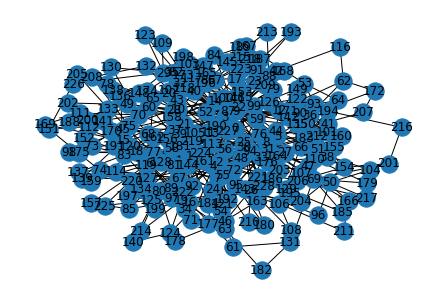

In [45]:
import numpy as np

# Parámetros para la simulación
n = 229  # Número de nodos
m = 2    # Número de conexiones que se agregan en cada paso

nx_graph_pa = nx.Graph()

# Agregar los primeros m nodos iniciales
for i in range(m):
    nx_graph_pa.add_node(i)

# Realizar la simulación de Preferential Attachment
for i in range(m, n):
    # Calcular la probabilidad de conexión para cada nodo existente
    degrees = [nx_graph_pa.degree(node) for node in nx_graph_pa.nodes()]
    
    if sum(degrees) == 0:
        # En caso de que todos los grados sean cero, asigna una probabilidad uniforme
        probabilities = [1 / m] * m
    else:
        # Normalizar las probabilidades para que sumen 1
        probabilities = np.array(degrees) / sum(degrees)
    
    # Elegir m nodos existentes para conectar el nuevo nodo
    targets = np.random.choice(nx_graph_pa.nodes(), size=m, p=probabilities, replace=False)
    
    # Agregar el nuevo nodo y las conexiones
    nx_graph_pa.add_node(i)
    for target in targets:
        nx_graph_pa.add_edge(i, target)

nx.draw(nx_graph_pa, with_labels=True)
plt.show()

## c. Obtener una representación de anonymous walks tanto de la red original como para las dos simuladas en los puntos a y b. Determinar por distancia coseno cuál sería la simulación más afín.

In [51]:
from node2vec import Node2Vec
from sklearn.metrics.pairwise import cosine_distances

# Representaciones de Caminatas Anónimas para la red original
node2vec_original = Node2Vec(nx_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model_original = node2vec_original.fit(window=10, min_count=1)

# Representaciones de Caminatas Anónimas para la red Erdős-Rényi
node2vec_er = Node2Vec(nx_graph_erdos_renyi, dimensions=64, walk_length=30, num_walks=200, workers=4)
model_er = node2vec_er.fit(window=10, min_count=1)

# Representaciones de Caminatas Anónimas para la red Preferential Attachment
node2vec_pa = Node2Vec(nx_graph_pa, dimensions=64, walk_length=30, num_walks=200, workers=4)
model_pa = node2vec_pa.fit(window=10, min_count=1)

# Obtener representaciones de nodos
embeddings_original = model_original.wv
embeddings_er = model_er.wv
embeddings_pa = model_pa.wv

Computing transition probabilities:   0%|          | 0/229 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/229 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/229 [00:00<?, ?it/s]

In [52]:
# Función para calcular la distancia coseno promedio entre dos conjuntos de representaciones
def average_coseno_distance(embeddings1, embeddings2):
    coseno_distances = cosine_distances(embeddings1, embeddings2)
    # Calcula la distancia coseno promedio
    return coseno_distances.mean()

# Convierte las representaciones de nodos en arrays bidimensionales
embeddings_er_array = embeddings_er.vectors
embeddings_pa_array = embeddings_pa.vectors
embeddings_original_array = embeddings_original.vectors

# Calcular distancias coseno entre las representaciones
coseno_distance_er_original = average_coseno_distance(embeddings_er_array, embeddings_original_array)
coseno_distance_pa_original = average_coseno_distance(embeddings_pa_array, embeddings_original_array)

# Compara las distancias coseno para determinar cuál simulación es más afín a la red original
if coseno_distance_er_original < coseno_distance_pa_original:
    print("La simulación de Erdős-Rényi es más afín a la red original.")
else:
    print("La simulación de Preferential Attachment es más afín a la red original.")

La simulación de Preferential Attachment es más afín a la red original.


# Punto 5
## Calcular los motifs de hasta 5 nodos de la subred definida en el punto 2b.
Para este cálculo utilizaremos la subred formada por la comunidad 3 obtenida en el punto 2b.

In [65]:
from networkx.algorithms import isomorphism

# Crear un grafo para cada tamaño de motif (de 1 a 5 nodos)
motif_graphs = [nx.subgraph(subgraph, nodes) for nodes in nx.enumerate_all_cliques(subgraph) if len(nodes) <= 5]

# Identificar motifs únicos
unique_motifs = []
for motif in motif_graphs:
    is_unique = True
    for unique in unique_motifs:
        GM = isomorphism.GraphMatcher(motif, unique)
        if GM.is_isomorphic():
            is_unique = False
            break
    if is_unique:
        unique_motifs.append(motif)

for i, motif in enumerate(unique_motifs, start=1):
    print(f"Motif {i}: Nodos: {motif.nodes}, Enlaces: {motif.edges}")

Motif 1: Nodos: ['Peru'], Enlaces: []
Motif 2: Nodos: ['Peru', 'Ecuador'], Enlaces: [('Peru', 'Ecuador')]
Motif 3: Nodos: ['Peru', 'Ecuador', 'Venezuela'], Enlaces: [('Peru', 'Venezuela'), ('Peru', 'Ecuador'), ('Ecuador', 'Venezuela')]
Motif 4: Nodos: ['Colombia', 'Peru', 'Ecuador', 'Venezuela'], Enlaces: [('Colombia', 'Ecuador'), ('Colombia', 'Peru'), ('Colombia', 'Venezuela'), ('Peru', 'Venezuela'), ('Peru', 'Ecuador'), ('Ecuador', 'Venezuela')]
Motif 5: Nodos: ['Peru', 'Brazil', 'Ecuador', 'Venezuela', 'Colombia'], Enlaces: [('Peru', 'Venezuela'), ('Peru', 'Ecuador'), ('Peru', 'Colombia'), ('Peru', 'Brazil'), ('Brazil', 'Ecuador'), ('Brazil', 'Venezuela'), ('Brazil', 'Colombia'), ('Ecuador', 'Venezuela'), ('Ecuador', 'Colombia'), ('Venezuela', 'Colombia')]


Otra forma de calcular motifs:

In [68]:
from motifs.calculos import calcular_motifs, significance_profile, motif_grafo_eleatorios
from metricas import distribucion_grados
from modelos import configuration_model
from motifs.graficos import graficar_significant_profile

ModuleNotFoundError: No module named 'motifs'

In [74]:
import multiprocessing as mp
import itertools
from numpy import linalg as LA
from os import cpu_count
import numpy as np
import time
import networkx as nx
from math import log as ln, sqrt
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import random


def alfa_preferential_attachment(grafo, x_m):
    """
    Calcula por maxima verosimilitud el valor del exponente de la ley de potencias a la que corresponde un grafo.
    :param grafo:
    :param x_m: valor a partir del cual se empieza a cumplir la ley de potencias
    :return: alfa
    """
    sumatoria = 0
    for v in grafo:
        cant_ady = len(list(grafo.neighbors(v)))
        if cant_ady >= x_m:
            sumatoria += ln(cant_ady / x_m)
    return 1 + len(grafo) / sumatoria


def distribucion_grados(grafo):
    """
    :param grafo:
    :return: distribucion de los grados del grafo
    """
    max_k = 0
    for v in grafo:
        k_v = len(list(grafo.neighbors(v)))
        if k_v > max_k:
            max_k = k_v

    grados = [0] * (max_k + 1)
    for v in grafo:
        grados[len(list(grafo.neighbors(v)))] += 1
    return np.array(grados)


def grado_promedio(grafo):
    """
    :param grafo:
    :return: grado promedio (k) del grafo
    """
    total = 0
    for v in grafo:
        total += len(list(grafo.neighbors(v)))
    return total / len(grafo)


def distrubucion_ccdf(grafo):
    distribucion = distribucion_grados(grafo)
    total = sum(distribucion)
    ccdf = [total]
    for i in range(1, len(distribucion)):
        ccdf.append(ccdf[i - 1] - distribucion[i - 1])
    return np.array(ccdf) / total


def graficar_distribuciones(distribucion_grados):
    rango = np.arange(len(distribucion_grados))
    plt.plot(rango, distribucion_grados)

    # Para obtener el valor de alfa vistualmente
    x_m = 4
    alpha_prima = 1.7
    exponencial = list(map(lambda k: 5 * k ** (-alpha_prima), rango[x_m:]))
    plt.plot(rango[x_m:], exponencial)
    print("Alfa: ", alpha_prima + 1)

    plt.xlabel("Grado k")
    plt.ylabel("Nk (Pk * N)")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Distribucion de grados")
    plt.show()


def coeficiente_clustering(grafo, v):
    adyacentes = list(grafo.neighbors(v))
    if (len(adyacentes)) < 2:
        return 0
    aristas_cl = 0
    visitados = set()
    for u in adyacentes:
        for w in adyacentes:
            if u == w or w in visitados:
                continue
            if grafo.has_edge(u, w):
                # ida y vuelta
                aristas_cl += 2
        visitados.add(u)
    grado = len(adyacentes)
    return aristas_cl / ((grado - 1) * grado)


def clustering(grafo):
    """
    :param grafo:
    :return: el coeficiente de clustering discriminado por grado de vertice, y el coeficiente de clustering total
    """
    grados = distribucion_grados(grafo)
    clustering_total = 0
    clustering_por_grado = [0] * len(grados)
    for v in grafo:
        cl_v = coeficiente_clustering(grafo, v)
        clustering_total += cl_v
        grado = len(list(grafo.neighbors(v)))
        clustering_por_grado[grado] += cl_v / (grados[grado])
    clustering_total /= len(grafo)
    return clustering_por_grado, clustering_total


def distancia_coseno(a, b):
    return 1 - np.inner(a, b) / (LA.norm(a) * LA.norm(b))


def distancia_euclidea(a, b):
    return LA.norm(a - b)


def knn(vectores, k=None, tipo_distancia="coseno"):
    if not k:
        k = int(sqrt(len(vectores)))
    if tipo_distancia == "coseno":
        distancia = distancia_coseno
    elif tipo_distancia == "euclidea":
        distancia = distancia_euclidea
    else:
        raise ValueError("Tipo de distancia desconocida")
    nucleos = random.sample(vectores, k)
    cores = {n[0]: [] for n in nucleos}
    for name, vec in vectores:
        mas_cercano = min(nucleos, key=lambda nuc: distancia(vec, nuc[1]))
        cores[mas_cercano[0]].append(name)
    return cores.values()

CORES = cpu_count()


def sub_grafo(grafo, vertices):
    if nx.is_directed(grafo):
        g = nx.DiGraph()
    else:
        g = nx.Graph()
    g.add_nodes_from(vertices)
    for v in vertices:
        for w in vertices:
            if grafo.has_edge(v, w):
                g.add_edge(v, w)
    return g


def extension(grafo, w, v_ext_org, v_sub):
    new_ext = set(v_ext_org)
    # primero agrego todos
    for x in grafo.neighbors(w):
        for v in v_sub:
            if not grafo.has_edge(v, x):
                new_ext.add(x)

    # ahora saco todos los menores, que no se llegan gracias a mi
    for x in v_ext_org:
        if x <= w and x in new_ext:
            new_ext.remove(x)

    return new_ext


def _esu(grafo, v, k, v_sub, v_ext, q):
    if len(v_sub) == k:
        q.put(sub_grafo(grafo, v_sub))
        return

    for w in v_ext:
        if w in v_sub:
            continue
        v_ext_mod = extension(grafo, w, v_ext, v_sub) - set([w]) - v_sub
        _esu(grafo, w, k, v_sub | set([w]), v_ext_mod, q)


def esperar_procesos(proc):
    for p in proc:
        p.join()
    proc.clear()


def esu(grafo, k, q):
    processes = []
    i = 0
    for v in grafo:
        v_ext = set((w for w in grafo.neighbors(v) if w > v))
        v_sub = set()
        v_sub.add(v)
        p = mp.Process(target=_esu, args=(grafo, v, k, v_sub, v_ext, q))
        p.start()
        processes.append(p)
        i += 1
        if len(processes) == CORES:
            esperar_procesos(processes)
            print("Termine con " + str(i))

    esperar_procesos(processes)
    print("Termine todos")


def son_isomorfos(g1, g2):
    if sum(map(lambda v: len(list(g1.neighbors(v))), g1)) != sum(map(lambda v: len(list(g2.neighbors(v))), g2)):
        return False, None

    trans_g2 = []
    g1_names = [n for n in g1]
    for permutation in itertools.permutations(list(range(len(g1)))):
        rename = {}
        for i in range(len(permutation)):
            rename[i + 1] = g1_names[permutation[i]]
        trans_g2.append(rename)

    for trans in trans_g2:
        es_isomorfo = True
        for i in range(1, len(g1) + 1):
            if set(g1.neighbors(trans[i])) != set(map(lambda v: trans[v], g2.neighbors(i))):
                es_isomorfo = False
        if es_isomorfo:
            return True, trans

    return False, None


def calcular_motif(grafo, motifs):
    for i in range(len(motifs)):
        isom, trans = son_isomorfos(grafo, motifs[i])
        if isom:
            return i, trans
    raise ValueError("Grafo: " + str(grafo) + " NO FUE ISOMORFO CON NINGUNO")


def consumir_motifs(q, result_queue, motifs):
    conteo = [0] * len(motifs)
    while True:
        subg = q.get()
        if len(subg) == 0:
            break
        idx_motif, _ = calcular_motif(subg, motifs)
        conteo[idx_motif] += 1
    result_queue.put(conteo)


def consumir_graphlets(g, q, n, result_queue, motifs):
    conteos = {v: np.zeros(n) for v in g}
    while True:
        subg = q.get()
        if len(subg) == 0:
            break
        idx, tx = calcular_motif(subg, motifs)
        for num in tx:
            conteos[tx[num]][motifs[idx].nodes[num]["type"]] += 1
    result_queue.put(conteos)


def contar_motifs(motifs, q, paralelismo):
    procesos = []
    results = mp.Queue()
    for i in range(paralelismo):
        p = mp.Process(target=consumir_motifs, args=(q, results, motifs))
        p.start()
        procesos.append(p)

    conteo_final = [0] * len(motifs)
    for p in procesos:
        p.join()
        parcial = results.get()
        for i in range(len(conteo_final)):
            conteo_final[i] += parcial[i]

    return conteo_final


def calcular_graphlets(g, motifs, q, n, paralelismo):
    procesos = []
    results = mp.Queue()
    for i in range(paralelismo):
        p = mp.Process(target=consumir_graphlets, args=(g, q, n, results, motifs))
        p.start()
        procesos.append(p)

    conteo_final = {v: np.zeros(n) for v in g}
    for p in procesos:
        p.join()
        parcial = results.get()
        for v in g:
            conteo_final[v] += parcial[v]

    return conteo_final


def aplicar_conteo_motifs(motifs, q, paralelismo, queue=None):
    resultados = contar_motifs(motifs, q, paralelismo)
    if queue is not None:
        queue.put(resultados)
    else:
        print(resultados)


def aplicar_conteo_graphlets(grafo, motifs, q, n, paralelismo, queue=None):
    resultados = calcular_graphlets(grafo, motifs, q, n, paralelismo)
    if queue is not None:
        queue.put(resultados)
    else:
        print(resultados)


def _elegir_motifs(grafo, n):
    return (MOTIF_DIR[n] if nx.is_directed(grafo) else MOTIF_NO_DIR[n])()


def calcular_motifs(grafo, n_motifs):
    """
    Algoritmo que calcula los motifs presentes dentro de grafo pasado por parámetro.
    Para optimizar, este procesamiento se paraleliza (con multiprocesamiento) con un modelo productor-consumidor:
    Se van calculando (en paralelo, con len(grafo) procesos) los subgrafos presentes con el algoritmo ESU, se
    envían estos subgrafos por una cola que luego unos consumidores irán consumiendo (también, en paralelo) para
    contar con los motifs.
    :param grafo:
    :param motifs: Los motifs a obtener. Tienen que corresponder todos a los motifs de misma cantidad de nodos
    y tienen que ser todos los motifs posibles.
    :param queue: Cola a la cual dejar los resultados. Si es null, simplemente se imprimirán los resultados
    """
    initial = 2 if nx.is_directed(grafo) else 3
    q = mp.Queue()
    r = mp.Queue()

    results = []
    for i in range(initial, n_motifs + 1):
        motifs = _elegir_motifs(grafo, i)
        k = len(motifs[0])
        p1 = mp.Process(target=esu, args=(grafo, k, q))
        p1.start()
        p2 = mp.Process(target=aplicar_conteo_motifs, args=(motifs, q, CORES, r))
        p2.start()
        p1.join()
        # ponemos grafo nulo para marcar fin
        for j in range(CORES):
            q.put(nx.Graph())
        p2.join()
        results += r.get()
    return np.array(results)


def significance_profile(N_real, N_rand_prom, N_rand_stds):
    """
    :param N_real: Cantidades de motifs encontrados en la red real
    :param N_rand_prom: promedio de motifs encontrados en red baseline simulada (varias veces)
    :param N_rand_stds: desviaciones standard de dichas cantidades simuladas
    :return: Significant profile (SP)
    """
    Z = (N_real - N_rand_prom) / (N_rand_stds + 0.001)
    norma = LA.norm(Z)
    SP = Z / norma
    return SP


def motif_grafo_eleatorios(generador_baseline, n_motifs, iters=100):
    """
    La funcion calcula baselines para luego hacer comparaciones de motifs
    :param generador_baseline: Una función sin parámetros (supplier) que devuelve un modelo
    aleatorizado (ver el módulo modelos.py)
    :param conjuntos_motifs: Conjuntos de motifs a calcular las metrias. Se debe reibir una
    lista de listas: [ [MOTIFS_2_VERTICES], [MOTIFS_3_VERTICES], ... ], dado que el calculo
    para cada motif se hace en funcion de la cantidad de nodos, como indica en #calcular_motifs_en_paralelo
    :param iters: cantidad de iteraciones a realizar
    :return: los promedios y desvios estándar de cada motif
    """
    conteos = []
    t = time.time()
    for i in range(iters):
        print("Iteracion {}".format(i + 1) + (("; anterior: {:.2f} segs".format(time.time() - t)) if i > 0 else ""))
        t = time.time()
        g = generador_baseline()
        print("Grafo generado, vamos por motifs")
        conteos.append(calcular_motifs(g, n_motifs))
        print(conteos[-1])

    valores = np.array(conteos)
    promedios = np.mean(valores, axis=0)
    stds = np.std(valores, axis=0)
    return promedios, stds


def graphlet_degree_vector(grafo, n):
    '''
    Por ahora solo funciona para no dirigido
    :param grafo:
    :param n:
    :return:
    '''
    max_graph = MOTIF_NO_DIR[n]()[-1]
    max_idx = max_graph[max(max_graph, key=lambda v:max_graph[v])]
    gdv = {v: np.zeros(max_idx + 1) for v in grafo}
    for v in grafo:
        gdv[v][0] = len(grafo.neighbors(v))

    paralellism = CORES // (1 if n == 3 else 2 if n == 4 else 8 if n == 5 else CORES)
    print("paralellism: " + str(paralellism))
    for i in range(3, n+1):
        q = mp.Manager().Queue()
        result = mp.Queue()
        p1 = mp.Process(target=esu, args=(grafo, i, q))
        p1.start()
        motifs = MOTIF_NO_DIR[i]()
        p2 = mp.Process(target=aplicar_conteo_graphlets, args=(grafo, motifs, q, max_idx + 1, 1, result))
        p2.start()
        print("Started, waiting to finish creating subgraphs")
        p1.join()
        print("Finished creating subgraphs")
        # ponemos grafo nulo para marcar fin
        for i in range(CORES):
            q.put(nx.Graph())
        p2.join()
        print("Finished to calculate, summing results")

        result = result.get()
        for v in grafo:
            gdv[v] += result[v]

    return gdv

def graficar_significant_profile(sp, extra_text=None):
    """
    Hace un gráfico del significant profile calculado
    :param sp:
    """
    plt.bar(range(1, len(sp) + 1), sp)
    plt.xticks(range(1, len(sp) + 1))
    plt.hlines(0, 1, len(sp), linestyles="dashed", colors="lightblue")
    plt.ylabel("Significance Profile")
    plt.title("Significant profile per motif" + ((" - " + extra_text) if extra_text is not None else ""))
    plt.show()

    
def configuration_model(distribucion_grados, n=None):
    if n is None:
        n = sum(distribucion_grados)
    g = nx.Graph()
    g.add_nodes_from(range(n))
    num_v = 0
    spokes = []
    for grado in range(len(distribucion_grados)):
        cant_con_grado = distribucion_grados[grado]
        for i in range(cant_con_grado):
            for j in range(grado):
                spokes.append(num_v)
            num_v += 1

    uniones = []
    while len(spokes) >= 2:
        v = random.choice(spokes)
        spokes.remove(v)
        w = random.choice(spokes)
        spokes.remove(w)
        uniones.append((v, w))

    for v, w in uniones:
        if v == w:
            continue
        g.add_edge(v, w)

    return g

import networkx as nx

'''
GRAFOS NO DIRIGIDOS:
'''


def MOTIF_NO_DIR_3():
    g = []
    for i in range(2):
        g.append(nx.Graph())
    #g1
    g[0].add_edge(1, 2)
    g[0].add_edge(1, 3)
    g[0].nodes[1]["type"] = 2
    g[0].nodes[2]["type"] = 1
    g[0].nodes[3]["type"] = 1
    #g2
    g[1].add_edge(1, 2)
    g[1].add_edge(1, 3)
    g[1].add_edge(2, 3)
    g[1].nodes[1]["type"] = 3
    g[1].nodes[2]["type"] = 3
    g[1].nodes[3]["type"] = 3
    return g


def MOTIF_NO_DIR_4():
    g = []
    for i in range(6):
        g.append(nx.Graph())
    #g3
    g[0].add_edge(1, 2)
    g[0].add_edge(3, 2)
    g[0].add_edge(3, 4)
    g[0].nodes[1]["type"] = 4
    g[0].nodes[4]["type"] = 4
    g[0].nodes[2]["type"] = 5
    g[0].nodes[3]["type"] = 5
    #g4
    g[1].add_edge(1, 2)
    g[1].add_edge(3, 2)
    g[1].add_edge(2, 4)
    g[1].nodes[1]["type"] = 6
    g[1].nodes[2]["type"] = 7
    g[1].nodes[3]["type"] = 6
    g[1].nodes[4]["type"] = 6
    #g5
    g[2].add_edge(1, 2)
    g[2].add_edge(3, 2)
    g[2].add_edge(3, 4)
    g[2].add_edge(1, 4)
    g[2].nodes[1]["type"] = 8
    g[2].nodes[2]["type"] = 8
    g[2].nodes[3]["type"] = 8
    g[2].nodes[4]["type"] = 8
    #g6
    g[3].add_edge(1, 2)
    g[3].add_edge(3, 2)
    g[3].add_edge(3, 1)
    g[3].add_edge(3, 4)
    g[3].nodes[3]["type"] = 11
    g[3].nodes[4]["type"] = 9
    g[3].nodes[1]["type"] = 10
    g[3].nodes[2]["type"] = 10
    #g7
    g[4].add_edge(1, 2)
    g[4].add_edge(3, 2)
    g[4].add_edge(3, 4)
    g[4].add_edge(1, 4)
    g[4].add_edge(1, 3)
    g[4].nodes[1]["type"] = 13
    g[4].nodes[3]["type"] = 13
    g[4].nodes[2]["type"] = 12
    g[4].nodes[4]["type"] = 12
    #g8
    g[5].add_edge(1, 2)
    g[5].add_edge(3, 2)
    g[5].add_edge(3, 4)
    g[5].add_edge(1, 4)
    g[5].add_edge(1, 3)
    g[5].add_edge(2, 4)
    g[5].nodes[1]["type"] = 14
    g[5].nodes[2]["type"] = 14
    g[5].nodes[3]["type"] = 14
    g[5].nodes[4]["type"] = 14
    return g


def MOTIF_NO_DIR_5():
    g = []
    for i in range(21):
        g.append(nx.Graph())
    #g9
    g[0].add_edge(1, 2)
    g[0].add_edge(3, 2)
    g[0].add_edge(3, 4)
    g[0].add_edge(4, 5)
    g[0].nodes[1]["type"] = 15
    g[0].nodes[2]["type"] = 16
    g[0].nodes[3]["type"] = 17
    g[0].nodes[4]["type"] = 16
    g[0].nodes[5]["type"] = 15
    #g10
    g[1].add_edge(1, 2)
    g[1].add_edge(3, 2)
    g[1].add_edge(2, 4)
    g[1].add_edge(5, 1)
    g[1].nodes[5]["type"] = 18
    g[1].nodes[4]["type"] = 19
    g[1].nodes[5]["type"] = 19
    g[1].nodes[1]["type"] = 20
    g[1].nodes[2]["type"] = 21
    #g11
    g[2].add_edge(1, 2)
    g[2].add_edge(1, 3)
    g[2].add_edge(1, 4)
    g[2].add_edge(1, 5)
    g[2].nodes[1]["type"] = 23
    g[2].nodes[2]["type"] = 22
    g[2].nodes[3]["type"] = 22
    g[2].nodes[4]["type"] = 22
    g[2].nodes[5]["type"] = 22
    #g12
    g[3].add_edge(1, 2)
    g[3].add_edge(3, 2)
    g[3].add_edge(3, 1)
    g[3].add_edge(3, 4)
    g[3].add_edge(5, 2)
    g[3].nodes[5]["type"] = 24
    g[3].nodes[4]["type"] = 24
    g[3].nodes[1]["type"] = 25
    g[3].nodes[2]["type"] = 26
    g[3].nodes[3]["type"] = 26
    #g13
    g[4].add_edge(1, 2)
    g[4].add_edge(3, 2)
    g[4].add_edge(3, 1)
    g[4].add_edge(3, 4)
    g[4].add_edge(4, 5)
    g[4].nodes[5]["type"] = 27
    g[4].nodes[4]["type"] = 28
    g[4].nodes[3]["type"] = 30
    g[4].nodes[2]["type"] = 29
    g[4].nodes[1]["type"] = 29
    #g14
    g[5].add_edge(1, 2)
    g[5].add_edge(3, 2)
    g[5].add_edge(3, 1)
    g[5].add_edge(3, 4)
    g[5].add_edge(3, 5)
    g[5].nodes[4]["type"] = 31
    g[5].nodes[5]["type"] = 31
    g[5].nodes[3]["type"] = 33
    g[5].nodes[1]["type"] = 32
    g[5].nodes[2]["type"] = 32
    #g15
    g[6].add_edge(1, 2)
    g[6].add_edge(3, 2)
    g[6].add_edge(3, 4)
    g[6].add_edge(5, 4)
    g[6].add_edge(5, 1)
    g[6].nodes[1]["type"] = 34
    g[6].nodes[2]["type"] = 34
    g[6].nodes[3]["type"] = 34
    g[6].nodes[4]["type"] = 34
    g[6].nodes[5]["type"] = 34
    #g16
    g[7].add_edge(1, 2)
    g[7].add_edge(3, 2)
    g[7].add_edge(3, 4)
    g[7].add_edge(1, 4)
    g[7].add_edge(5, 1)
    g[7].nodes[5]["type"] = 35
    g[7].nodes[1]["type"] = 38
    g[7].nodes[2]["type"] = 37
    g[7].nodes[4]["type"] = 37
    g[7].nodes[3]["type"] = 36
    #17
    g[8].add_edge(1, 2)
    g[8].add_edge(3, 2)
    g[8].add_edge(3, 4)
    g[8].add_edge(1, 4)
    g[8].add_edge(1, 3)
    g[8].add_edge(5, 1)
    g[8].nodes[5]["type"] = 39
    g[8].nodes[1]["type"] = 42
    g[8].nodes[2]["type"] = 40
    g[8].nodes[4]["type"] = 40
    g[8].nodes[3]["type"] = 41
    #18
    g[9].add_edge(1, 2)
    g[9].add_edge(1, 3)
    g[9].add_edge(2, 3)
    g[9].add_edge(1, 4)
    g[9].add_edge(1, 5)
    g[9].add_edge(4, 5)
    g[9].nodes[1]["type"] = 44
    g[9].nodes[2]["type"] = 43
    g[9].nodes[3]["type"] = 43
    g[9].nodes[4]["type"] = 43
    g[9].nodes[5]["type"] = 43
    #19
    g[10].add_edge(1, 2)
    g[10].add_edge(3, 2)
    g[10].add_edge(3, 4)
    g[10].add_edge(1, 4)
    g[10].add_edge(5, 1)
    g[10].add_edge(2, 4)
    g[10].nodes[5]["type"] = 45
    g[10].nodes[1]["type"] = 47
    g[10].nodes[2]["type"] = 48
    g[10].nodes[4]["type"] = 48
    g[10].nodes[3]["type"] = 46
    #g20
    g[11].add_edge(1, 2)
    g[11].add_edge(1, 3)
    g[11].add_edge(1, 4)
    g[11].add_edge(5, 2)
    g[11].add_edge(5, 3)
    g[11].add_edge(5, 4)
    g[11].nodes[1]["type"] = 50
    g[11].nodes[5]["type"] = 50
    g[11].nodes[2]["type"] = 49
    g[11].nodes[3]["type"] = 49
    g[11].nodes[4]["type"] = 49
    #g21
    g[12].add_edge(1, 2)
    g[12].add_edge(3, 2)
    g[12].add_edge(3, 1)
    g[12].add_edge(3, 4)
    g[12].add_edge(4, 5)
    g[12].add_edge(5, 2)
    g[12].nodes[2]["type"] = 53
    g[12].nodes[3]["type"] = 53
    g[12].nodes[5]["type"] = 51
    g[12].nodes[1]["type"] = 52
    g[12].nodes[4]["type"] = 51
    #g22
    g[13].add_edge(1, 2)
    g[13].add_edge(3, 2)
    g[13].add_edge(1, 3)
    g[13].add_edge(4, 2)
    g[13].add_edge(4, 3)
    g[13].add_edge(5, 2)
    g[13].add_edge(5, 3)
    g[13].nodes[2]["type"] = 55
    g[13].nodes[3]["type"] = 55
    g[13].nodes[1]["type"] = 54
    g[13].nodes[4]["type"] = 54
    g[13].nodes[5]["type"] = 54
    #g23
    g[14].add_edge(1, 2)
    g[14].add_edge(1, 3)
    g[14].add_edge(1, 4)
    g[14].add_edge(3, 2)
    g[14].add_edge(3, 4)
    g[14].add_edge(2, 4)
    g[14].add_edge(1, 5)
    g[14].nodes[5]["type"] = 56
    g[14].nodes[1]["type"] = 58
    g[14].nodes[2]["type"] = 57
    g[14].nodes[3]["type"] = 57
    g[14].nodes[4]["type"] = 57
    #g24
    g[15].add_edge(1, 2)
    g[15].add_edge(2, 3)
    g[15].add_edge(1, 3)
    g[15].add_edge(2, 4)
    g[15].add_edge(3, 4)
    g[15].add_edge(2, 5)
    g[15].add_edge(4, 5)
    g[15].nodes[2]["type"] = 61
    g[15].nodes[5]["type"] = 59
    g[15].nodes[1]["type"] = 59
    g[15].nodes[4]["type"] = 60
    g[15].nodes[3]["type"] = 60
    #g25
    g[16].add_edge(1, 2)
    g[16].add_edge(1, 3)
    g[16].add_edge(1, 4)
    g[16].add_edge(5, 2)
    g[16].add_edge(5, 3)
    g[16].add_edge(5, 4)
    g[16].add_edge(3, 4)
    g[16].nodes[2]["type"] = 62
    g[16].nodes[5]["type"] = 63
    g[16].nodes[1]["type"] = 63
    g[16].nodes[4]["type"] = 64
    g[16].nodes[3]["type"] = 64
    #g26
    g[17].add_edge(1, 2)
    g[17].add_edge(3, 2)
    g[17].add_edge(1, 3)
    g[17].add_edge(4, 2)
    g[17].add_edge(4, 3)
    g[17].add_edge(5, 2)
    g[17].add_edge(5, 3)
    g[17].add_edge(4, 5)
    g[17].nodes[1]["type"] = 65
    g[17].nodes[2]["type"] = 67
    g[17].nodes[3]["type"] = 67
    g[17].nodes[4]["type"] = 66
    g[17].nodes[5]["type"] = 66
    #g27
    g[18].add_edge(1, 2)
    g[18].add_edge(2, 3)
    g[18].add_edge(3, 4)
    g[18].add_edge(4, 1)
    g[18].add_edge(5, 1)
    g[18].add_edge(5, 2)
    g[18].add_edge(5, 3)
    g[18].add_edge(5, 4)
    g[18].nodes[1]["type"] = 68
    g[18].nodes[2]["type"] = 68
    g[18].nodes[3]["type"] = 68
    g[18].nodes[4]["type"] = 68
    g[18].nodes[5]["type"] = 69
    #g28
    g[19].add_edge(1, 2)
    g[19].add_edge(1, 3)
    g[19].add_edge(1, 4)
    g[19].add_edge(2, 3)
    g[19].add_edge(2, 4)
    g[19].add_edge(2, 5)
    g[19].add_edge(3, 4)
    g[19].add_edge(3, 5)
    g[19].add_edge(4, 5)
    g[19].nodes[1]["type"] = 70
    g[19].nodes[2]["type"] = 71
    g[19].nodes[3]["type"] = 71
    g[19].nodes[4]["type"] = 71
    g[19].nodes[5]["type"] = 70
    #g29
    g[20].add_edge(1, 2)
    g[20].add_edge(1, 3)
    g[20].add_edge(1, 4)
    g[20].add_edge(1, 5)
    g[20].add_edge(2, 3)
    g[20].add_edge(2, 4)
    g[20].add_edge(2, 5)
    g[20].add_edge(3, 4)
    g[20].add_edge(3, 5)
    g[20].add_edge(4, 5)
    g[20].nodes[1]["type"] = 72
    g[20].nodes[2]["type"] = 72
    g[20].nodes[3]["type"] = 72
    g[20].nodes[4]["type"] = 72
    g[20].nodes[5]["type"] = 72

    return g


MOTIF_NO_DIR = {3: MOTIF_NO_DIR_3, 4: MOTIF_NO_DIR_4, 5: MOTIF_NO_DIR_5}


'''
GRAFOS DIRIGIDOS:
'''


def MOTIF_DIR_2():
    g = []
    for i in range(2):
        g.append(nx.DiGraph())
    g[0].add_edge(1, 2)
    g[1].add_edge(1, 2)
    g[1].add_edge(2, 1)
    return g


def MOTIF_DIR_3():
    g = []
    for i in range(13):
        g.append(nx.DiGraph())

    g[0].add_edge(1, 2)
    g[0].add_edge(1, 3)
    g[1].add_edge(2, 1)
    g[1].add_edge(3, 1)
    g[2].add_edge(1, 2)
    g[2].add_edge(2, 3)
    g[3].add_edge(1, 2)
    g[3].add_edge(2, 3)
    g[3].add_edge(3, 2)
    g[4].add_edge(1, 2)
    g[4].add_edge(2, 1)
    g[4].add_edge(2, 3)
    g[5].add_edge(1, 2)
    g[5].add_edge(2, 1)
    g[5].add_edge(3, 2)
    g[5].add_edge(2, 3)
    g[6].add_edge(1, 2)
    g[6].add_edge(1, 3)
    g[6].add_edge(2, 3)
    g[7].add_edge(1, 2)
    g[7].add_edge(2, 3)
    g[7].add_edge(3, 1)
    g[8].add_edge(1, 2)
    g[8].add_edge(1, 3)
    g[8].add_edge(2, 3)
    g[8].add_edge(3, 2)
    g[9].add_edge(3, 2)
    g[9].add_edge(2, 3)
    g[9].add_edge(3, 1)
    g[9].add_edge(2, 1)
    g[10].add_edge(1, 2)
    g[10].add_edge(2, 3)
    g[10].add_edge(3, 1)
    g[10].add_edge(1, 3)
    g[11].add_edge(2, 3)
    g[11].add_edge(3, 2)
    g[11].add_edge(2, 1)
    g[11].add_edge(3, 1)
    g[11].add_edge(1, 3)
    g[12].add_edge(1, 2)
    g[12].add_edge(1, 3)
    g[12].add_edge(2, 1)
    g[12].add_edge(2, 3)
    g[12].add_edge(3, 1)
    g[12].add_edge(3, 2)
    return g


MOTIF_DIR = {2: MOTIF_DIR_2, 3: MOTIF_DIR_3}

'''
GRAFOS HOMOFILIA NO DIRIGIDO:
'''

'''
GRAFOS HOMOFILIA DIRIGIDO:
'''

'''
GRAFOS TEMPORAL NO DIRIGIDO:
'''

'''
GRAFOS TEMPORAL DIRIGIDO:
'''

'\nGRAFOS TEMPORAL DIRIGIDO:\n'

In [77]:
MAX_NODOS_MOTIFS = 5
motifs = calcular_motifs(subgraph, MAX_NODOS_MOTIFS)
print(motifs)

Termine con 8
Termine con 16
Termine con 24
Termine con 32
Termine con 40
Termine con 48
Termine todos
Termine con 8
Termine con 16
Termine con 24
Termine con 32
Termine con 40
Termine con 48
Termine todos
Termine con 8
Termine con 16
Termine con 24
Termine con 32
Termine con 40
Termine con 48
Termine todos
[ 2549   625 12093  8303  1140 13310  3793   815 33154 73020 19559 49298
 41193 56600  2067 19530 57779 11757 38094  1409 14010  5766 28791 25709
  5180 17385  1995  4308   685]


In [ ]:
dist = distribucion_grados(subgraph)
promedios, stds = motif_grafo_eleatorios(lambda: configuration_model(dist), MAX_NODOS_MOTIFS, iters=20)
SP = significance_profile(motifs, promedios, stds)
print("SP:", SP)

Iteracion 1
Grafo generado, vamos por motifs
Termine con 8
Termine con 16
Termine con 24
Termine con 32
Termine con 40
Termine con 48
Termine todos
Termine con 8
Termine con 16
Termine con 24
Termine con 32
Termine con 40
Termine con 48
Termine todos
Termine con 8
Termine con 16
Termine con 24
Termine con 32
Termine con 40
Termine con 48
Termine todos
[  2678    221  16593   9474   3264   6989   1225     56  67760 112612
  18582  43089  24016  31821  11128  66703  28281   2857  18211   8401
  29743   1593   3426   9245   9162   1776   1219    174      4]
Iteracion 2; anterior: 270.37 segs
Grafo generado, vamos por motifs
Termine con 8
Termine con 16
Termine con 24
Termine con 32
Termine con 40
Termine con 48
Termine todos
Termine con 8
Termine con 16
Termine con 24
Termine con 32
Termine con 40
Termine con 48
Termine todos
Termine con 8
Termine con 16
Termine con 24
Termine con 32
Termine con 40
Termine con 48
Termine todos
[  2550    194  15245   9620   2440   6141   1095     45  6235

In [ ]:
graficar_significant_profile(SP, 'Red de vuelos')

## b. Calcular el promedio y desvío estandar de los motifs de una red de baseline. Calcular el significant profile de la red, y hacer un gráfico.

In [67]:
G_baseline = nx_graph
baseline_motifs = [nx.subgraph(G_baseline, nodes) for nodes in nx.enumerate_all_cliques(G_baseline) if len(nodes) <= 5]

# 2. Calcular el promedio y la desviación estándar de los motifs en la red de baseline
motif_counts_baseline = [len(list(nx.enumerate_all_cliques(G_baseline, i))) for i in range(1, 6)]
promedio_baseline = sum(motif_counts_baseline) / len(motif_counts_baseline)
desviacion_estandar_baseline = np.std(motif_counts_baseline)

# 3. Calcular los motifs en la red de interés (la subred definida en el punto 2b)
G_subred = subgraph
subred_motifs = [nx.subgraph(G_subred, nodes) for nodes in nx.enumerate_all_cliques(G_subred) if len(nodes) <= 5]

# 4. Calcular el perfil significativo de la red de interés comparándola con la red de baseline
from networkx.algorithms.approximation import random_reference
random_baseline = random_reference(G_subred, niter=100)

motif_counts_subred = [len(list(nx.enumerate_all_cliques(G_subred, i))) for i in range(1, 6)]
promedio_subred = sum(motif_counts_subred) / len(motif_counts_subred)
desviacion_estandar_subred = np.std(motif_counts_subred)

# Gráfico que muestra la diferencia entre la red de interés y la red de referencia
import matplotlib.pyplot as plt

x = range(1, 6)
diferencia_promedio = [promedio_subred - promedio_baseline] * 5
diferencia_desviacion_estandar = [desviacion_estandar_subred - desviacion_estandar_baseline] * 5

plt.figure(figsize=(8, 6))
plt.plot(x, diferencia_promedio, label='Diferencia en Promedio')
plt.plot(x, diferencia_desviacion_estandar, label='Diferencia en Desviación Estándar')
plt.xlabel('Tamaño del Motif')
plt.ylabel('Diferencia')
plt.title('Perfil Significativo de Motifs')
plt.legend()
plt.grid(True)
plt.show()

NetworkXNotImplemented: not implemented for directed type

## c. Intentar dar con una explicación del resultado obtenido en el punto anterior

# Punto 6
## Detectar los roles en dicha red utilizando el algoritmo RolX, explicando el resultado obtenido.
Para este punto utilizamos el algoritmo provisto por la cátedra obtenido de:
https://github.com/mbuchwald/social-networks-utils

In [19]:
from graphrole import RecursiveFeatureExtractor, RoleExtractor

def extract_roles_and_plot(G, title='',save = False ,file_name='', big=False):
    feature_extractor = RecursiveFeatureExtractor(G)
    features = feature_extractor.extract_features()
    role_extractor = RoleExtractor(n_roles=None)
    role_extractor.extract_role_factors(features)
    labels = {node: node for node in G.nodes()}

    available_colors = {'role_0':'#E9D758', 'role_1':'#297373', 'role_2':'#ff8552', 'role_3':'#888888', 'role_4':'#00aa00','role_5':'#aaaa00','role_6':'#aa0000' , 'role_7':'#0000aa'}
    
    colors = [available_colors[role_extractor.roles[node]] for node in G.nodes()]
    
    pos = nx.kamada_kawai_layout(G)
    if big:
        plt.figure(figsize=(15,15))
    else:
        plt.figure(figsize=(10,10))
    plt.title(title)

    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=colors, alpha=0.7, node_size=700, linewidths=2)
    nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels=labels)
    
    if save:
        plt.savefig(file_name, format = 'svg', dpi=300)

ImportError: cannot import name 'ParserError' from 'dateutil.parser' (/usr/lib/python3/dist-packages/dateutil/parser/__init__.py)

In [ ]:
extract_roles_and_plot(g,title='Roles red de vuelos', save=False, file_name='img/roles_punto6.svg')

# Punto 7
## Determinar los puentes (globales o locales) en dicha red.
Para obtener los puentes necesitamos transformar nuestro grafo en un grafo no dirigido para poder utilizar la función nx.bridges. Luego para cada puente encontrado se procede a eliminar dicha arista del grafo y se verifica si se divide la red en componentes disjuntas.

In [33]:
undirected_graph = nx.Graph(nx_graph)

# Encontrar los puentes en el grafo no dirigido
bridges = list(nx.bridges(undirected_graph))

print("Puentes en la red:")
for bridge in bridges:
    undirected_graph_copy = undirected_graph.copy()
    undirected_graph_copy.remove_edge(*bridge)
    
    # Verificar si la eliminación de la arista dividió la red en componentes disjuntas
    components = list(nx.connected_components(undirected_graph_copy))
    if len(components) == 1:
        print(f"Puente global: {bridge}")
    else:
        print(f"Puente local: {bridge}")

Puentes en la red:
Puente local: ('Fiji', 'Tuvalu')
Puente local: ('Canada', 'Saint Pierre and Miquelon')
Puente local: ('United States', 'American Samoa')
Puente local: ('United Kingdom', 'Saint Helena')
Puente local: ('New Zealand', 'Niue')
Puente local: ('Antigua and Barbuda', 'Montserrat')
Puente local: ('South Africa', 'Swaziland')
Puente local: ('South Africa', 'Lesotho')
Puente local: ('Burma', 'Myanmar')
